In [1]:
import glob
import os
import re
import json
import itertools
import bisect
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)
FONT_SIZE = 24
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title


In [2]:
def get_pvalue_mapping(values):
    sz = len(values)
    return [(val, (sz-idx)/sz) for idx, val in enumerate(sorted(values))]

def get_pvalue(mapping, val):
    idx = bisect.bisect_left(mapping, (val, -1))
    if idx == 0:
        return 1.0
    else:
        return mapping[idx-1][1]

# values = [1,2,3]
# mapping = get_pvalue_mapping(values)
# print(mapping)
# print([get_pvalue(mapping, x) for x in [0.5, 1.5, 2.5, 3.5]])

In [3]:
data_types = ['PBM', 'CHS', 'SMS', 'AFS-LYS', 'AFS-IVT', 'AFS-GFPIVT', 'HTS-LYS', 'HTS-IVT', 'HTS-GFPIVT']
all_triples = []
for heatmap_fn in glob.glob('heatmaps/*.json'):
    tf = re.sub(r'\.json$', '', os.path.basename(heatmap_fn))
    with open(heatmap_fn) as f:
        data = json.load(f)['data']

    for ds_info in data:
        ds_1 = ds_info['name']
        for corr_info in ds_info['data']:
            ds_2 = corr_info['x']
            val = corr_info['y']
            if ds_1 < ds_2:
                all_triples.append(((ds_1.split(':')[0], ds_1), (ds_2.split(':')[0], ds_2), val))

print('triples loaded')



triples loaded


In [4]:
with open('good_datasets.txt') as f:
    good_datasets = set(l.strip() for l in f.readlines())

with open('artifact_datasets.json') as f:
    artifact_datasets = json.load(f)

In [5]:
# dt_stats_all = {}
# for data_types_pair in itertools.combinations_with_replacement(data_types, 2):
#     vals = [val  for ((dt_1, ds_1), (dt_2, ds_2), val) in all_triples 
#                      if sorted((dt_1, dt_2)) == sorted(data_types_pair)]
#     dt_stats_all[tuple(sorted(data_types_pair))] = vals

datatypes_1 = []
datatypes_2 = []
values = []
for (dt_1, ds_1), (dt_2, ds_2), val in all_triples:
#     if (ds_1.split(':')[1] not in good_datasets) or (ds_2.split(':')[1] not in good_datasets):
#         continue
    datatypes_1.append(dt_1)
    datatypes_2.append(dt_2)
    values.append(val)
    if dt_1 != dt_2:
        datatypes_1.append(dt_2)
        datatypes_2.append(dt_1)
        values.append(val)
df = pd.DataFrame({
    'datatype_1': datatypes_1,
    'datatype_2': datatypes_2,
    'value': values,
})
print('made dataframe')

made dataframe


In [6]:
mappings = defaultdict(dict)
for dt1 in data_types:
    for dt2 in data_types:
        vals = list(df[(df.datatype_1 == dt1) & (df.datatype_2 == dt2)]['value'])
        mappings[dt1][dt2] = get_pvalue_mapping(vals)
# mappings

In [7]:
dataset_pvalues = defaultdict(lambda: defaultdict(list))
for ((dt1,ds1),(dt2,ds2), val) in all_triples:
    # ToDo: сначала агрегировать внутри типа данных
    pvalue = get_pvalue(mappings[dt1][dt2], val)
    dataset_pvalues[ds1][dt2].append(pvalue)
    dataset_pvalues[ds2][dt1].append(pvalue)


/home/ilya/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:8621: RuntimeWarning: divide by zero encountered in log1p
  statistic = -np.sum(np.log(pvalues)) + np.sum(np.log1p(-pvalues))


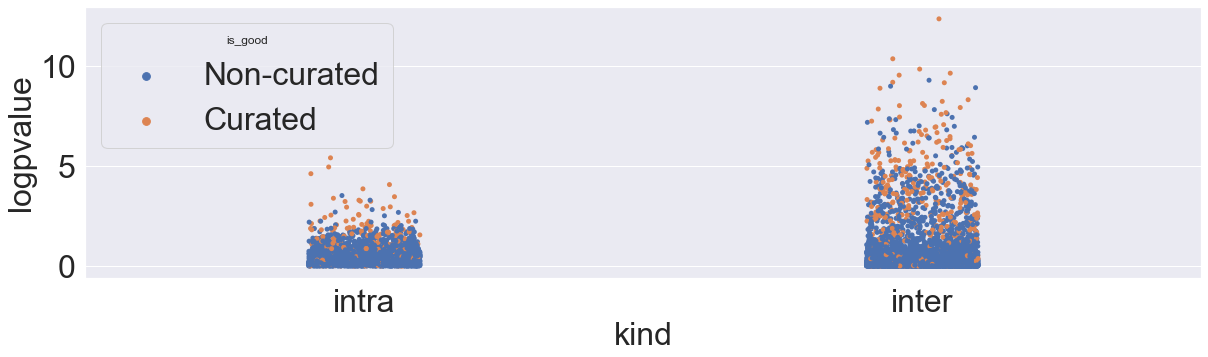

In [17]:
import functools
import scipy
import math

ds_pvalue = {}
ds_pvalue_self = {}
ds_pvalue_other = {}
for ds1 in dataset_pvalues:
    dt1 = ds1.split(':')[0]
    pvalues_dt_aggregated = {}
    for dt2, pvalues in dataset_pvalues[ds1].items():
        if len(pvalues) > 0:
            _, agg_pval = scipy.stats.combine_pvalues(pvalues, method='mudholkar_george')
            pvalues_dt_aggregated[dt2] = agg_pval

    _, pvalue_agg = scipy.stats.combine_pvalues(list(pvalues_dt_aggregated.values()), method='mudholkar_george')
    ds_pvalue[ds1] = -math.log10(pvalue_agg)
    
    if len(dataset_pvalues[ds1][dt1]) != 0:
        pvalue_self_dt = pvalues_dt_aggregated[dt1]
        ds_pvalue_self[ds1] = -math.log10(pvalue_self_dt)

    pvalues_dt_aggregated_other_dt = {k: v for k,v in pvalues_dt_aggregated.items() if k != dt1}
    if len(pvalues_dt_aggregated_other_dt) > 0:
        _, pvalue_other_agg = scipy.stats.combine_pvalues(list(pvalues_dt_aggregated_other_dt.values()), method='mudholkar_george')
        ds_pvalue_other[ds1] = -math.log10(pvalue_other_agg)

datasets = []
logpvals = []
is_good = []
kind = []
for ds, pval in ds_pvalue.items():
    datasets.append(ds)
    logpvals.append(pval)
    is_good.append('Curated' if ds.split(':')[1] in good_datasets else 'Non-curated')
    kind.append('all')

datasets_self = []
logpvals_self = []
is_good_self = []
for ds, pval in ds_pvalue_self.items():
    datasets_self.append(ds)
    logpvals_self.append(pval)
    is_good_self.append('Curated' if ds.split(':')[1] in good_datasets else 'Non-curated')
    
    datasets.append(ds)
    logpvals.append(pval)
    is_good.append('Curated' if ds.split(':')[1] in good_datasets else 'Non-curated')
    kind.append('intra')

datasets_other = []
logpvals_other = []
is_good_other = []
for ds, pval in ds_pvalue_other.items():
    datasets_other.append(ds)
    logpvals_other.append(pval)
    is_good_other.append('Curated' if ds.split(':')[1] in good_datasets else 'Non-curated')
    
    datasets.append(ds)
    logpvals.append(pval)
    is_good.append('Curated' if ds.split(':')[1] in good_datasets else 'Non-curated')
    kind.append('inter')

    
df = pd.DataFrame({'logpvalue': logpvals, 'dataset': datasets, 'is_good': is_good, 'kind': kind})
# df = df.iloc[0:100]
# sns.violinplot(x='kind', hue='is_good', hue_order=['Non-curated', 'Curated'], y='logpvalue', data=df[df.kind != 'all'])
sns.stripplot(x='kind', hue='is_good', hue_order=['Non-curated', 'Curated'], y='logpvalue', data=df[df.kind != 'all'])
# plt.savefig('logpval_distribution.png')
# sns.kdeplot(ds_pvalue.values())
# sns.swarmplot(ds_pvalue.values())

In [ ]:
datasets = []
all_pvals = []
self_pvals = []
other_pvals = []
is_good = []
datasets = []
for ds in ds_pvalue_self.keys() & ds_pvalue_other.keys():
    all_pvals.append(ds_pvalue[ds])
    self_pvals.append(ds_pvalue_self[ds])
    other_pvals.append(ds_pvalue_other[ds])
    is_good.append('Curated' if ds.split(':')[1] in good_datasets else 'Non-curated')
    datasets.append(ds)
df = pd.DataFrame({'dataset': datasets, 'intra': self_pvals, 'inter': other_pvals, 'all': all_pvals, 'good_curated': is_good})
sns.scatterplot(x='intra', y='inter', hue='good_curated', hue_order=['Non-curated', 'Curated'], alpha=0.6, data=df)
# df.dataset.value_counts()
# plt.save('')
# df.to_csv('dataset_pvalues.tsv', sep='\t')

In [ ]:
df.good_curated.value_counts()

In [ ]:
metadata = []
with open('metadata_release_8d.json') as f:
    for line in f:
        metadata.append(json.loads(line))

In [ ]:
tf_by_expname = {}
for info in metadata:
    exp = info['experiment_id']
    replica = info.get('experiment_params', {}).get('replica')
    if replica:
        exp = f'{exp}.Rep-{replica}'
    tf = info['tf']
    if (exp in tf_by_expname) and tf_by_expname[exp] != tf:
        raise Exception('Error')
    tf_by_expname[exp] = tf

# tf_by_expname

In [ ]:
datasets = []
all_pvals = []
self_pvals = []
other_pvals = []
is_curated = []
is_artifact = []
dt_agg_pvals = defaultdict(list)
dt_agg_sizes = defaultdict(list)
other_counts = []
total_counts = []
self_sizes = []
exp_types = []
tfs = []
for ds in ds_pvalue.keys():
    datasets.append(ds)
    dt1, exp_id = ds.split(':')
    exp_types.append(dt1)
    tfs.append(tf_by_expname[exp_id])

    all_pvals.append(ds_pvalue[ds])
    self_pvals.append(ds_pvalue_self.get(ds))
    other_pvals.append(ds_pvalue_other.get(ds))
    is_curated.append('Curated' if ds.split(':')[1] in good_datasets else 'Non-curated')
    is_artifact.append('Artifact' if ds.split(':')[1] in artifact_datasets else 'Non-artifact')
    
    total_count = 0
    other_count = 0
    for dt2 in data_types:
        pvalues = dataset_pvalues[ds][dt2]
        if len(pvalues) > 0:
            _, agg_pval = scipy.stats.combine_pvalues(pvalues, method='mudholkar_george')
        else:
            agg_pval = None
        dt_agg_pvals[dt2].append(agg_pval)
        dt_agg_sizes[dt2].append(len(pvalues))
        total_count += len(pvalues)
        if dt2 != dt1:
            other_count += len(pvalues)

    total_counts.append(total_count)
    other_counts.append(other_count)
    self_sizes.append(len(dataset_pvalues[ds][dt1]))
    
    for dt2 in data_types:
        len(dataset_pvalues[ds][dt2])
df = pd.DataFrame({'tf': tfs, 'experiment_type': exp_types, 'dataset': datasets,
                   'is_curated': is_curated, 'is_artifact': is_artifact,
                   'all_logpval': all_pvals, 'all_count': total_counts,
                   'intra_logpval': self_pvals, 'intra_count': self_sizes,
                   'inter_logpval': other_pvals, 'inter_count': other_counts,
                   })
for dt in data_types:
    df[f'{dt}_logpval'] = dt_agg_pvals[dt]
    df[f'{dt}_count'] = dt_agg_sizes[dt]

# sns.scatterplot(x='intra_logpval', y='inter_logpval', hue='is_curated', hue_order=['Non-curated', 'Curated'], alpha=1.0, data=df)
sns.scatterplot(x='intra_logpval', y='inter_logpval', hue='is_artifact', hue_order=['Non-artifact', 'Artifact'], alpha=1.0, data=df)
# plt.xlim(0, 13)
# plt.ylim(0, 13)
plt.savefig('ds_pvals_scatterplot.png')
plt.figure()
sns.scatterplot(x='intra_logpval', y='inter_logpval', hue='is_curated', hue_order=['Non-curated', 'Curated'], alpha=1.0, data=df[(df.inter_logpval <= 1) & (df.intra_logpval <= 1)])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('ds_pvals_scatterplot_lowpval.png')

# df.dataset.value_counts()
df.to_csv('dataset_pvalues.tsv', sep='\t')
df

In [10]:
# sns.scatterplot(x='self', y='other', hue='is_good', hue_order=['Non-curated', 'Curated'], alpha=0.6, data=df[(df.self <= 1) & (df.other <= 1)])

# print(*sorted(list(df[(df.self <= 1) & (df.other <= 1) & (df.is_good == 'Curated')].dataset)), sep='\n')
# print(df[df.dataset == 'AFS-LYS:YWO_B_AffSeq_A12_ZBTB47-FL'])
# sns.scatterplot(x='self', y='other', hue='is_good', hue_order=['Non-curated', 'Curated'], alpha=0.6, data=df[df.dataset == 'AFS-LYS:YWO_B_AffSeq_A12_ZBTB47-FL'])
# print((df).shape)
# print((df[df.dataset == 'AFS-LYS:YWO_B_AffSeq_A12_ZBTB47-FL']).shape)
# print((df[(df.self <= 1) & (df.other <= 1)]).shape)

AttributeError: 'DataFrame' object has no attribute 'datatype_1'

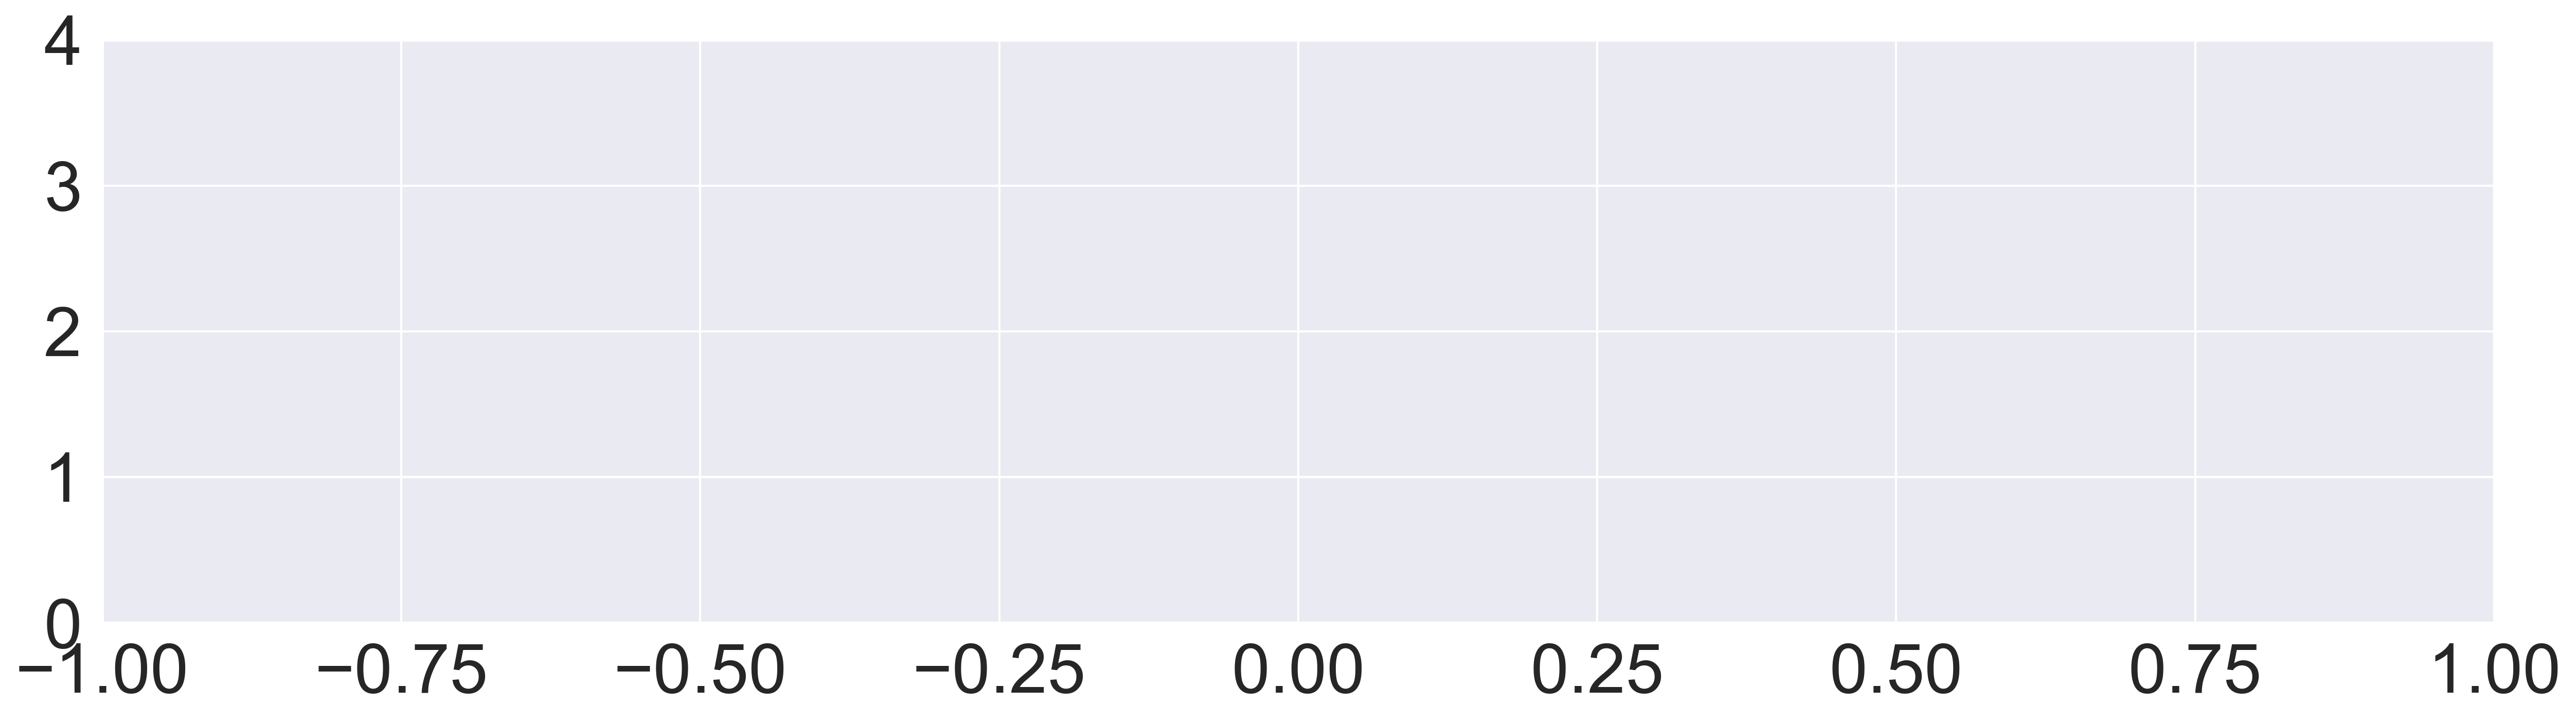

In [11]:
sns.set(rc={
    'figure.figsize':(20, 5),
#     'figure.font': {
#         'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22,
#     }
})

FONT_SIZE = 32
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title


for dt_1 in data_types:
    other_data_types = data_types #set(data_types) - {dt_1}
    for dt_2 in other_data_types:
        plt.figure(dpi=300)
        plt.xlim(-1, 1)
        plt.ylim(0, 4)
#         plt.title(f"{dt_1} vs {dt_2} and itself")
        sns.kdeplot(data = df[(df.datatype_1 == dt_1) & (df.datatype_2 == dt_2)], x='value')
        sns.kdeplot(data = df[(df.datatype_1 == dt_1) & (df.datatype_2 == dt_1)], x='value')
        sns.kdeplot(data = df[(df.datatype_1 == dt_1)], x='value')
        sns.kdeplot(data = df, x='value')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.axvline(x=0, linewidth=1)
        plt.legend(labels = [f'{dt_1} vs {dt_2}', f'{dt_1} vs itself', f'{dt_1} vs all', f'all vs all'])
        plt.savefig(f'corr_tmp/corr_{dt_1}_vs_{dt_2}.png')
        plt.close()

    images = [Image.open(f'corr_tmp/corr_{dt_1}_vs_{dt_2}.png') for dt_2 in other_data_types]
    widths, heights = zip(*(i.size for i in images))

    max_height = max(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width * 3, (max_height + 10) * 3),color='white')

    y_offset = 5
    x_offset = 0
    for idx, im in enumerate(images):

        new_im.paste(im, (x_offset, y_offset))
        y_offset += im.size[1] + 10
        if (1 + idx) % 3 == 0:
            y_offset = 5
            x_offset += max_width

    new_im.save(f'corr_{dt_1}.png')
#     new_im.show()

In [26]:
df[(df.datatype_1 == 'HTS-LYS') & (df.datatype_2 == 'HTS-GFPIVT')].describe()

,value
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [27]:
df[(df.datatype_1 == 'HTS-GFPIVT') & (df.datatype_2 == 'HTS-LYS')].describe()

,value
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [23]:
df

,datatype_1,datatype_2,value
0,SMS,SMS,0.651
1,HTS-IVT,SMS,0.486
2,SMS,HTS-IVT,0.486
3,HTS-IVT,SMS,0.421
4,SMS,HTS-IVT,0.421
...,...,...,...
1725,HTS-LYS,AFS-IVT,-0.131
1726,CHS,HTS-LYS,0.626
1727,HTS-LYS,CHS,0.626
1728,CHS,HTS-LYS,0.603


In [ ]:
import glob
import os
import re
import json
import itertools

def mean(vals):
    if len(vals) == 0:
        return None
    return sum(vals) / len(vals)

def stats(vals):
    return {'count': len(vals), 'mean': mean(vals), 'values': vals}

data_types = ['PBM', 'CHS', 'SMS', 'AFS-LYS', 'AFS-IVT', 'AFS-GFPIVT', 'HTS-LYS', 'HTS-IVT', 'HTS-GFPIVT']

data_all = {}
all_triples = []
for heatmap_fn in glob.glob('heatmaps/*.json'):
    tf = re.sub(r'\.json$', '', os.path.basename(heatmap_fn))
#     print(tf)
    with open(heatmap_fn) as f:
        data = json.load(f)['data']
    data_all[tf] = data

    triples = []
    for ds_info in data:
        ds_1 = ds_info['name']
        for corr_info in ds_info['data']:
            ds_2 = corr_info['x']
            val = corr_info['y']
            if ds_1 < ds_2:
                triples.append(((ds_1.split(':')[0], ds_1), (ds_2.split(':')[0], ds_2), val))
                all_triples.append(((ds_1.split(':')[0], ds_1), (ds_2.split(':')[0], ds_2), val))

    dt_stats = {}
    for data_types_pair in itertools.combinations_with_replacement(data_types, 2):
        # matching_triples = [((dt_1, ds_1), (dt_2, ds_2), val)  for ((dt_1, ds_1), (dt_2, ds_2), val) in triples  if sorted((dt_1, dt_2)) == sorted(data_types_pair)]
        vals = [val  for ((dt_1, ds_1), (dt_2, ds_2), val) in triples  if sorted((dt_1, dt_2)) == sorted(data_types_pair)]
        info = [*sorted(data_types_pair), stats(vals)]
        dt_stats[tuple(sorted(data_types_pair))] = stats(vals)
#         print(info)
#     break

dt_stats_all = {}
for data_types_pair in itertools.combinations_with_replacement(data_types, 2):
    # matching_triples = [((dt_1, ds_1), (dt_2, ds_2), val)  for ((dt_1, ds_1), (dt_2, ds_2), val) in triples  if sorted((dt_1, dt_2)) == sorted(data_types_pair)]
    vals = [val  for ((dt_1, ds_1), (dt_2, ds_2), val) in all_triples  if sorted((dt_1, dt_2)) == sorted(data_types_pair)]
    info = [*sorted(data_types_pair), stats(vals)]
    dt_stats[tuple(sorted(data_types_pair))] = stats(vals)
#     print(info)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

datatypes_1 = []
datatypes_2 = []
values = []
for (dt_1,dt_2), info in dt_stats.items():
    for val in info['values']:
        datatypes_1.append(dt_1)
        datatypes_2.append(dt_2)
        values.append(val)
        if dt_1 != dt_2:
            datatypes_1.append(dt_2)
            datatypes_2.append(dt_1)
            values.append(val)
df = pd.DataFrame({
    'datatype_1': datatypes_1,
    'datatype_2': datatypes_2,
    'value': values,
    'title': [f'{dt_1} vs {dt_2}' for dt_1,dt_2 in zip(datatypes_1,datatypes_2)],
})
# df

g = sns.FacetGrid(df, col="datatype_1", row="datatype_2", sharex=True, sharey=True)
g.set(xlim=(-1, 1))

# g.set_axis_labels("Total bill ($)", "Tip ($)")
g.set_titles(col_template="{col_name}", row_template="{row_name}", template="{col_name} vs {row_name}")
g.map(sns.kdeplot, "value")
g.tight_layout()
# plt.axvline(0)
# g.savefig('overall_distribution.png')


# for dt_pair, dt_pair_info in dt_stats.items():
#     plt.figure()
#     plt.xlim(-1,1)
#     sns.kdeplot(dt_pair_info['values']).set_title(dt_pair)

# sns.kdeplot(df, x='value')

In [ ]:
# from matplotlib import rcParams

# figure size in inches
# rcParams['figure.figsize'] = 11.7,8.27

# sns.set(rc={'figure.figsize':(35, 50)})
for dt in data_types:
    plt.figure()
    g = sns.FacetGrid(df[df.datatype_1 == dt], col="datatype_1", row="datatype_2", 
                      sharex=True, sharey=True, margin_titles=True, aspect=4)
    g.set(xlim=(-1, 1))

    g.set_titles(template="{col_name} vs {row_name}", col_template="{col_name}", row_template="{row_name}")
    g.map(sns.kdeplot, "value")
    g.tight_layout()
    g.map(plt.axvline, x=0, linewidth=1)
    
#     g2 = sns.FacetGrid(df[df.datatype_1 == df.datatype_2], col="datatype_1", row="datatype_2", 
#                       sharex=True, sharey=True, margin_titles=True, aspect=4)
#     g2.set(xlim=(-1, 1))
#     g.savefig(f'correlations_{dt}.png')
    break

In [ ]:
from PIL import Image

sns.set(rc={
    'figure.figsize':(20, 5),
#     'figure.font': {
#         'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22,
#     }
})

FONT_SIZE = 32
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title


for dt_1 in data_types:
    other_data_types = data_types #set(data_types) - {dt_1}
    for dt_2 in other_data_types:
        plt.figure()
        plt.xlim(-1, 1)
#         plt.title(f"{dt_1} vs {dt_2} and itself")
        sns.kdeplot(data = df[(df.datatype_1 == dt_1) & (df.datatype_2 == dt_2)], x='value')
        sns.kdeplot(data = df[(df.datatype_1 == dt_1) & (df.datatype_2 == dt_1)], x='value')
        sns.kdeplot(data = df[(df.datatype_1 == dt_1)], x='value')
        sns.kdeplot(data = df, x='value')
        plt.xlabel(None)
        plt.ylabel(None)
        plt.axvline(x=0, linewidth=1)
        plt.legend(labels = [f'{dt_1} vs {dt_2}', f'{dt_1} vs itself', f'{dt_1} vs all', f'all vs all'])
        plt.savefig(f'corr_tmp/corr_{dt_1}_vs_{dt_2}.png')

    images = [Image.open(f'corr_tmp/corr_{dt_1}_vs_{dt_2}.png') for dt_2 in other_data_types]
    widths, heights = zip(*(i.size for i in images))

    max_height = max(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width * 3, (max_height + 10) * 3),color='white')

    y_offset = 5
    x_offset = 0
    for idx, im in enumerate(images):

        new_im.paste(im, (x_offset, y_offset))
        y_offset += im.size[1] + 10
        if (1 + idx) % 3 == 0:
            y_offset = 5
            x_offset += max_width

    new_im.save(f'corr_{dt_1}.png')
#     new_im.show()

In [110]:
!pip freeze | grep scipy

scipy==1.7.2


In [111]:
!pip install -U scipy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 768.4 kB/s eta 0:00:00m eta 0:00:010:00:02
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.2
    Uninstalling scipy-1.7.2:
      Successfully uninstalled scipy-1.7.2

[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python3 -m pip install --upgrade pip
